In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import imageio
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D
from keras.optimizers import SGD, RMSprop
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils, generic_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from keras import backend as K
import sys
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import History

2024-06-07 10:39:59.336564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 10:39:59.393270: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-07 10:39:59.396369: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/infor/miniconda3/envs/torch/lib/python3.9/site-packages/cv2/../../lib64:
2024-06-07 10:39:59.396380: 

In [2]:
K.set_image_data_format('channels_first')
image_rows, image_columns, image_depth = 64, 64, 96
look_frames = int(image_depth/2)
num_classes = 3 # 分類類別 
process_detect = False # 要不要對資料做 detect 處理
version = True # F:舊版(39筆) 或 T:新版(269筆)


training_list = []
apexframe   = [[] for a in range(num_classes)] # 紀錄video的apex frame
ifsamevideo = [[] for a in range(num_classes)] # 紀錄clip與其前一個clip是否來自相同video
path = [[] for a in range(num_classes)]

if version:
    # anger
    apexframe[0]   = [572,2163,3371,3757,569,1675,1758,421,1391,1881,2162,2912,3421,3943,3270,1898,3447,3309,3563,1139,1979,2168,
                      2247,2641,3733,415,933,870,1694,2139,2197,3493,3808,416,587,886,1331,1529,1660,1716,1538,2281,2783,3210,
                      3405,3772,4031,3689,4343,3405]
    ifsamevideo[0] = [1,0,1,1,0,1,1,0,1,1,1,1,1,1,0,0,1,0,1,0,1,1,1,0,1,0,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,0]
    # happiness
    apexframe[1]   = [142,2218,2476,1412,329,1114,1415,1480,2207,77,400,997,1148,1358,1604,1703,1886,2261,858,1584,2291,2344,
                      3180,1771,2986,993,1137,1432,2774,115,2753,858,1094,1597,1875,848,1431,1658,1842,1957,2237,2697,3181,872,
                      966,140,203,183,341,569,1102,1451,2203,368,423,2234,1184,1779,1938,200,179,347,859,1195,1582,1936,1438,
                      1562,1166,2259,1691,3193,1616,2203,1054,2253,775,410,873,1590,2218,264,363,666,739,1105,1579,1764,2092,
                      2465,2683,1726,2234,1671,2338,1015,373,582,1087,861,1868,423,1182,1490,1963,2242,861,1587,1762,2044,2357,
                      2709,244,423,342,888,1197,1800,1882,1250,1390,1675,1790,1881,2239,613,1613,2707]
    ifsamevideo[1] = [1,1,0,0,0,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,0,1,1,0,0,0,0,1,1,1,0,1,1,1,1,1,1,1,0,1,0,1,0,1,1,1,1,1,
                      0,1,1,0,1,1,0,0,1,1,1,1,1,0,1,0,1,0,1,0,0,0,1,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,0,1,0,1,1,1,1,
                      0,1,1,1,1,1,0,1,0,1,1,1,1,0,1,1,1,1,1,0,1,0]
    # disgust
    apexframe[2]   = [703,559,1799,214,334,430,535,727,841,177,376,391,525,1571,1716,1840,316,912,335,530,732,925,1364,478,1003,
                      1017,321,434,428,880,1207,1713,39,377,559,804,1061,1460,357,785,412,572,756,1107,1426,1582,789,66,106,1296]
    ifsamevideo[2] = [1,0,1,0,1,1,1,1,0,0,0,1,1,1,1,1,0,1,0,1,1,1,0,0,1,0,0,1,0,1,1,1,0,1,1,1,1,0,0,1,0,1,1,1,1,1,0,0,0,0]

    path[0] = 'data-all/anger/'      #  50  video clips
    path[1] = 'data-all/happiness/'  #  128 video clips
    path[2] = 'data-all/disgust/'    #  50  video clips
    
else:
    # anger
    apexframe[0]   = [1898, 3447, 1139, 1979, 933, 1694, 2197, 3808]
    ifsamevideo[0] = [1, 1, 0, 1, 0, 0, 1, 1]
    # happiness
    apexframe[1]   = [142, 329, 400, 1703, 1886, 2291, 1842, 1957, 3239, 619, 423, 1054, 264, 423, 2239] 
    ifsamevideo[1] = [1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
    # disgust
    apexframe[2]   = [703, 559, 275, 335, 530, 732, 1003, 1013, 1024, 880, 39, 377, 1460, 1426, 1037, 106] 
    ifsamevideo[2] = [1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0]

    path[0] = 'data/angry/'    # 8  video clips
    path[1] = 'data/happy/'    # 15 video clips
    path[2] = 'data/disgust/'  # 16 video clips

cascade_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# 資料存檔/ 載入路徑
if process_detect:
    if version: imagefile = 'images_detect_new.npy'
    else: imagefile       = 'images_detect_old.npy'
else:
    if version: imagefile = 'images_new.npy'
    else: imagefile       = 'images_old.npy'

In [3]:
def video_clips(detect):
    for v in range(num_classes):
        k = 0 # index of directorylisting
        directorylisting = os.listdir(path[v])
        for i in range(len(apexframe[v])):
            if ifsamevideo[v][i] == False: # 目前短片與上一個短片來自不同影片，index k++
                k = k + 1
            video = directorylisting[k]
            videopath = path[v] + video
            loadedvideo = imageio.get_reader(videopath, 'ffmpeg')
            length = loadedvideo.count_frames() # 影片最大幀數

            # 邊界處理
            apex = apexframe[v][i]
            left  = apex - look_frames # 左 偏移量
            right = apex + look_frames # 右 偏移量
            if right > length:
                right = length
                left  = right - image_depth
            elif left < 0:
                left  = 0
                right = left + image_depth
            print("{:40}  left{:5}  apex{:5}  right{:5}". format(video, left, apex, right))

            # 沒有對資料做 detect 一樣的處理
            if detect == False:
                frames = [] 
                framerange = [x for x in range(left, right)] # 取apex frame的前後幾幀     
                for frame in framerange:
                    image = loadedvideo.get_data(frame)
                    imageresize = cv2.resize(image, (image_rows, image_columns), interpolation = cv2.INTER_AREA)
                    grayimage = cv2.cvtColor(imageresize, cv2.COLOR_BGR2GRAY)
                    frames.append(grayimage)
                """
                # 印出apex前後共15幀
                count = 0
                framerange = [apex + i for i in range(-7, 8)] 
                plt.figure(figsize=(15, 2))
                for frame in framerange:
                    count += 1
                    image = loadedvideo.get_data(frame)
                    imageresize = cv2.resize(image, (image_rows, image_columns), interpolation=cv2.INTER_AREA)
                    plt.subplot(1, 15, count)
                    plt.imshow(imageresize)
                    plt.axis('off') # 關閉刻度
                plt.tight_layout()
                plt.show()
                """
                
                frames = np.asarray(frames)
                videoarray = np.rollaxis(np.rollaxis(frames, 2, 0), 2, 0)
                training_list.append(videoarray)


            #對資料做 detect 一樣的處理    
            elif detect == True: 
                frames = [] 
                framerange = [x for x in range(left, right)] # 取apex frame的前後幀
                frame_count = 0 # 紀錄每個輸入影片的幀數
                for frame in framerange: # 將資料改為跟Detect一樣
                    image = loadedvideo.get_data(frame)
                    grayimage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    face_rects = cascade_classifier.detectMultiScale(grayimage, 1.2, 6) # 人臉偵測
                    for (x,y,w,h) in face_rects: # 偵測的框架
                        gray_roi = grayimage[y:y+h, x:x+w] # 框架區域
                        imageresize = cv2.resize(gray_roi, (image_rows, image_columns), interpolation = cv2.INTER_AREA)
                        frames.append(imageresize)
                        last_frame = imageresize # 紀錄最後一幀
                        frame_count += 1

                for a in range(frame_count, image_depth): # 不足96幀數的影片，都用最後一幀補滿
                    frames.append(last_frame)

                frames = np.asarray(frames)
                videoarray = np.rollaxis(np.rollaxis(frames, 2, 0), 2, 0)
                training_list.append(videoarray)
                print("video", i+1, np.asarray(videoarray).shape)

                plt.figure(figsize=(1, 1))
                plt.imshow(last_frame)
                plt.show()


video_clips(process_detect)  
np.save(imagefile, training_list)

37_0402beatingpregnantwoman.avi           left  524  apex  572  right  620
27_0402beatingpregnantwoman.avi           left 2115  apex 2163  right 2211
27_0402beatingpregnantwoman.avi           left 3323  apex 3371  right 3419
27_0402beatingpregnantwoman.avi           left 3709  apex 3757  right 3805
24_0402beatingpregnantwoman.avi           left  521  apex  569  right  617
24_0402beatingpregnantwoman.avi           left 1627  apex 1675  right 1723
24_0402beatingpregnantwoman.avi           left 1710  apex 1758  right 1806
16_0401girlcrashing.avi                   left  373  apex  421  right  469
16_0401girlcrashing.avi                   left 1343  apex 1391  right 1439
16_0401girlcrashing.avi                   left 1833  apex 1881  right 1929
16_0401girlcrashing.avi                   left 2114  apex 2162  right 2210
16_0401girlcrashing.avi                   left 2864  apex 2912  right 2960
16_0401girlcrashing.avi                   left 3373  apex 3421  right 3469
16_0401girlcrashing.avi  

In [4]:
for i in apexframe:
    print(len(i))
    
training_list = np.load(imagefile)

50
128
50


In [5]:
training_list = np.asarray(training_list)
trainingsamples = len(training_list)

# 設定label
traininglabels = np.zeros((trainingsamples, ), dtype = int) 
if version:
    traininglabels[0:50] = 0     # 50  video clips (anger)
    traininglabels[50:178] = 1   # 128 video clips (happiness)
    traininglabels[178:228] = 2  # 50  video clips (disgust)
else:
    traininglabels[0:8] = 0      #  8  video clips (anger)
    traininglabels[8:23] = 1     # 15  video clips (happiness)
    traininglabels[23:39] = 2    # 16  video clips (disgust)
traininglabels = np_utils.to_categorical(traininglabels, num_classes) # one-hot編碼

# 資料轉為五維
training_set = np.zeros((trainingsamples, 1, image_rows, image_columns, image_depth))
for h in range(trainingsamples):
    training_set[h][0][:][:][:] = training_list[h,:,:,:]
print(training_set.shape)

# 資料處理 標準化
training_set = training_set.astype('float32')
training_set -= np.mean(training_set) # 消除數據的偏差 (與其他資料集相比)
training_set /= np.max(training_set)  # 使數據介於0~1之間

(228, 1, 64, 64, 96)


In [6]:
def CNN_3D():
    model = Sequential()
    model.add(Convolution3D(32, (3, 3, 15), input_shape=(1, image_rows, image_columns, image_depth), activation='relu'))
    model.add(MaxPooling3D(pool_size=(3, 3, 3)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])
    return model

CNN_3D().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 32, 62, 62, 82)    4352      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 32, 20, 20, 27)   0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 20, 20, 27)    0         
                                                                 
 flatten (Flatten)           (None, 345600)            0         
                                                                 
 dense (Dense)               (None, 128)               44236928  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

2024-06-07 10:41:38.680978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-07 10:41:38.681111: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/infor/miniconda3/envs/torch/lib/python3.9/site-packages/cv2/../../lib64:
2024-06-07 10:41:38.681142: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/infor/miniconda3/envs/torch/lib/python3.9/site-packages/cv2/../../lib64:
2024-06-07 10:41:38.681166: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcub

In [18]:
history = History()
def train(model, X, y, epochs, batch_size = 32):
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)
    return history

In [15]:
# 資料切割
train_images, validation_images, train_labels, validation_labels = train_test_split(
        training_set, traininglabels, test_size=0.2, random_state=4, stratify=traininglabels)

# 資料分布
train_labels_int = np.argmax(train_labels, axis=1)
label_series = pd.Series(train_labels_int)
class_distribution = label_series.value_counts()
print(class_distribution)

1    102
0     40
2     40
dtype: int64


Label counts:
 0     40
1    102
2     40
dtype: int64
Alpha parameters for Dirichlet distribution:
 [0.21978022 0.56043956 0.21978022]


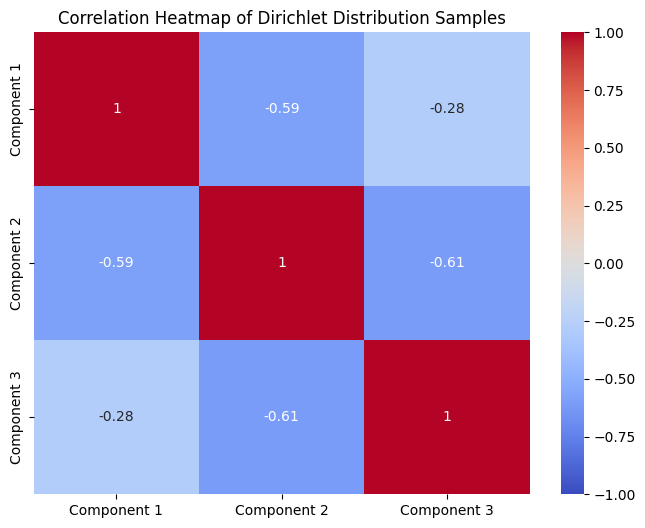

In [16]:
# Assuming train_labels_int is already defined and contains your label integers
train_labels_int = np.argmax(train_labels, axis=1)

# Calculate the count of each label
label_counts = pd.Series(train_labels_int).value_counts().sort_index()
print("Label counts:\n", label_counts)

# Normalize the label counts to use as alpha parameters for the Dirichlet distribution
alpha = label_counts.values / label_counts.sum()
print("Alpha parameters for Dirichlet distribution:\n", alpha)

# Generate samples from the Dirichlet distribution
samples = np.random.dirichlet(alpha, size=5000)

# Create a DataFrame for the samples
df_samples = pd.DataFrame(samples, columns=['Component 1', 'Component 2', 'Component 3'])

# Plot the heatmap of the correlations
plt.figure(figsize=(8, 6))
sns.heatmap(df_samples.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Dirichlet Distribution Samples')
plt.show()

In [17]:
def fed_avg(models):
    model_weights = [model.get_weights() for model in models]
    avg_weights = list()
    for weights_list_tuple in zip(*model_weights):
        avg_weights.append(
            np.array([np.array(weights_).mean(axis=0) for weights_ in zip(*weights_list_tuple)]))
    return avg_weights


Round 1 of 50
Training client 1 of 10
Training loss for client 1: 0.9117000699043274
Training client 2 of 10
Training loss for client 2: 0.8333785533905029
Training client 3 of 10
Training loss for client 3: 0.8270191550254822
Training client 4 of 10
Training loss for client 4: 0.7866678833961487
Training client 5 of 10
Training loss for client 5: 0.6089568734169006
Training client 6 of 10
Training loss for client 6: 0.8238226175308228
Training client 7 of 10
Training loss for client 7: 0.8950194120407104
Training client 8 of 10
Training loss for client 8: 0.6635467410087585
Training client 9 of 10
Training loss for client 9: 0.8024594783782959
Training client 10 of 10
Training loss for client 10: 1.0477356910705566
2/2 [==============================] - 1s 209ms/step - loss: 1.0935 - accuracy: 0.5652
Global model validation accuracy: 0.5652173757553101
Round 2 of 50
Training client 1 of 10
Training loss for client 1: 1.078033685684204
Training client 2 of 10
Training loss for client 2

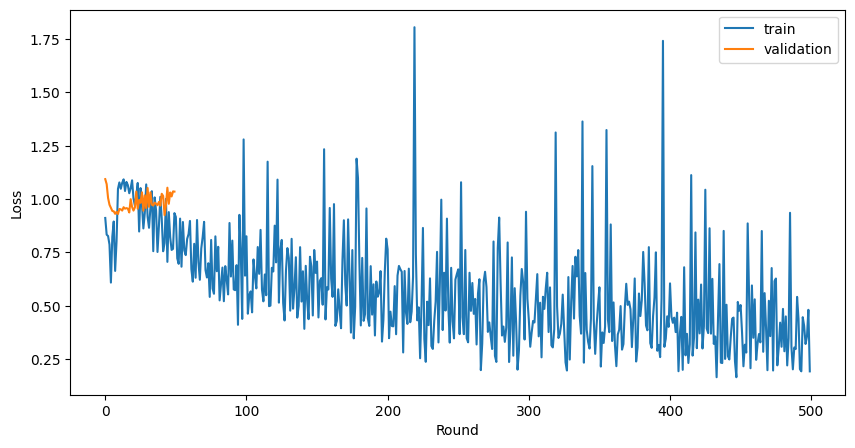

In [19]:
# Main federated learning training loop
NUM_CLIENTS = 10
NUM_ROUNDS = 50
epochs = 5

# Initialize models for each client
models = [CNN_3D() for _ in range(NUM_CLIENTS)]

# Split training data among clients
train_images_split = np.array_split(train_images, NUM_CLIENTS)
train_labels_split = np.array_split(train_labels, NUM_CLIENTS)

train_losses = []
test_losses = []

# Train models on client data

for i in range(NUM_ROUNDS):
    print(f"Round {i+1} of {NUM_ROUNDS}")
    for j in range(NUM_CLIENTS):
        print(f"Training client {j+1} of {NUM_CLIENTS}")
        history = train(models[j], train_images_split[j], train_labels_split[j], epochs=epochs)
        train_losses.append(history.history['loss'][-1])
        print(f"Training loss for client {j+1}: {history.history['loss'][-1]}")

    avg_weights = fed_avg(models)
    for model in models:
        model.set_weights(avg_weights)

    # Evaluate global model
    global_model = CNN_3D()
    global_model.set_weights(avg_weights)
    loss, acc = global_model.evaluate(validation_images, validation_labels)
    test_losses.append(loss)
    print(f"Global model validation accuracy: {acc}")

# 繪製訓練和測試損失
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='validation')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()
plt.show()